# Install tools

> uncomment to install

In [1]:
# !pip install numpy matplotlib pandas seaborn scikit-learn torch transformers wordcloud tqdm ntlk tabulate

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Settings

In [3]:
import matplotlib

SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

matplotlib.rcParams.update({
    'figure.titlesize': BIGGER_SIZE,
    'font.size': SMALL_SIZE, # Base font size
    'axes.labelsize': MEDIUM_SIZE, # Axis labels
    'axes.titlesize': MEDIUM_SIZE, # Title size
    'xtick.labelsize': SMALL_SIZE, # X-axis tick labels
    'ytick.labelsize': SMALL_SIZE, # Y-axis tick labels
    'legend.fontsize': SMALL_SIZE, # Legend text
})

# Dataset

Dataset from kaggle - [link](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/code?datasetId=18&searchQuery=Sentiment+Analysis).

Contents
- Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
- database.sqlite: Contains the table 'Reviews'

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

Contains 10 features:
- Id
- ProductId
- UserId
- ProfileName
- HelpfulnessNumerator - Number of users who found the review helpful
- HelpfulnessDenominator - Number of  user who either fount review helpful or not.
- Score - Rating given by the user
- Time - Time when the review was given by the user
- Summary - Brief summary of the review
- Text - Text of the review

> uncomment following two cell to install

In [4]:
# !curl -L -o ./reviews.zip https://www.kaggle.com/api/v1/datasets/download/snap/amazon-fine-food-reviews
# !unzip reviews.zip -d reviews

In [5]:
# raw_df = pd.read_csv("reviews/Reviews.csv")

# print("Basic Information and Structure")
# print("Shape:\n", raw_df.shape)
# print("Unique values:\n", raw_df.nunique())
# raw_df.describe().round(2)

# Data Cleaning

In [6]:
# clean_df = raw_df.copy()

# print("Shape:\t", clean_df.shape)

# clean_df['Summary'] = clean_df['Summary'].fillna(' ')
# clean_df['Combo'] = clean_df['Summary'] + ' ' + clean_df['Text']

# # # Missing Values
# # # Fom article:
# # # 
# # # There were 27 missing values in the variable “Summary”,
# # # and we replaced the missing values with a blank space.
# # # Then, we created a new variable, “Combo”, which combined
# # # the two variables “Summary” and variable “Text”.

# # ====================================================================
# # Duplicate Values
# # The dataset has many duplicate entries, so the duplicates are removed to get the unbiased results in further analysis of data.
# clean_df.drop_duplicates(subset=['Combo'], inplace=True)
# print("Shape after removing duplicates:\t", clean_df.shape)

# # ====================================================================
# # Punctuation and special character
# import re

# def clean_text(text):
#     text = text.lower() # Convert to lowercase
#     text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # Remove punctuation and special characters
#     text = re.sub(r"\s+", " ", text).strip() # Remove multiple spaces
#     return text

# clean_df['Combo'] = clean_df['Combo'].apply(clean_text)

# # ====================================================================
# # Time
# clean_df['Time'] = pd.to_datetime(clean_df['Time'], unit='s') # Convert Unix timestamp to datetime
# clean_df['Year'] = clean_df['Time'].dt.year # Create a 'Year' column
# clean_df = clean_df[clean_df['Year'] >= 2010].copy() # Keep only reviews from 2010 onward
# print("Shape after removing reviews before 2010:\t", clean_df.shape)

# clean_df = clean_df[['Combo', 'Score']].copy()
# print("Shape final:\t", clean_df.shape)

# clean_df.head()

# Score distribution

In [7]:
# score_counts = clean_df['Score'].value_counts().sort_index()  # Sort index so 1,2,3,4,5
# score_percentages = (score_counts / score_counts.sum()) * 100

# score_dist_df = pd.DataFrame({
#     'Score': score_counts.index,
#     'ScoreCount': score_counts.values,
#     'ScorePercentage': score_percentages.values.round(2)
# })

# score_dist_df

> The above graph shows the imbalance of score distribution within the data. The total proportion of Score 4 and 5 contains 76.8% of the total scores. If we kept all the data, then the model would be biased when deciding the correct score, or even purely guessing 5 could receive 62.6% on correctness. 

In [8]:
# # Data reselection based on length of reviews
# clean_df['length'] = clean_df['Combo'].apply(lambda x: len(x))
# clean_df = clean_df[clean_df['length'] >= 100].copy()
# clean_df.drop('length', axis=1, inplace=True)
# print("Shape keeping combo's with length 100:\t", clean_df.shape)

# plt.figure(figsize=(6, 4))
# sns.countplot(x='Score', data=clean_df, order=sorted(clean_df['Score'].unique()))
# plt.title('Distribution of Scores')
# plt.show()

# # ====================================================================
# # Resampling
# min_count_per_score = 15000
# sampled_df = (
#     clean_df.groupby('Score', group_keys=False)
#     .sample(n=min_count_per_score) 
#     .reset_index(drop=True)
# )
# # Adjust labels to be 0-indexed if needed (i.e., scores 1-5 become 0-4)
# sampled_df['Score'] = sampled_df['Score'] - 1

# print("Shape after resampling:\t", clean_df.shape)

# sampled_df.to_pickle("processed_reviews.pkl")

# Model Analysis

In [9]:
df = pd.read_pickle("processed_reviews.pkl")
df.head()

,Combo,Score
0,ick save your money i just bought a keurig and...,0
1,nasty animal hair in marrobones my dog loves m...,0
2,don t be fooled by the packaging this tea is u...,0
3,horrible i ll stick with swanson s this has a ...,0
4,coffee bean direct papua new guinea city roast...,0


In [10]:
# Check if correctly loaded 
print("both should be 0 =")
print(df.isnull().sum()) 
print("(75000, 2) =", df.shape)

X = df['Combo'].values
y = df['Score'].values

both should be 0 =
Combo    0
Score    0
dtype: int64
(75000, 2) = (75000, 2)


In [11]:
from sklearn.model_selection import train_test_split

# Split 70% for training, 10% for validation and 20% for testing 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

print("Train set size:", len(X_train))
print("validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 52500
validation set size: 7500
Test set size: 15000


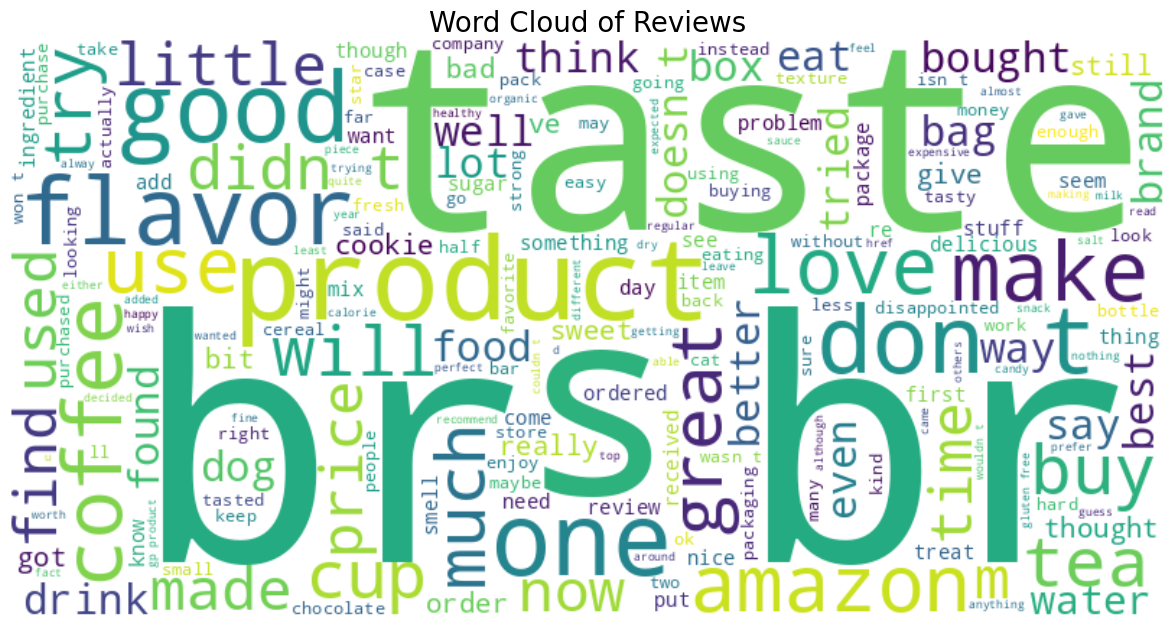

In [12]:
from wordcloud import WordCloud

# Combine all review texts
all_text = " ".join(df['Combo'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

## BERT Model

In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)

model = model.to(device)

2025-04-02 22:34:56.213738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743615296.226794 2008718 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743615296.230615 2008718 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743615296.242051 2008718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743615296.242070 2008718 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743615296.242072 2008718 computation_placer.cc:177] computation placer alr

In [14]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
from torch.utils.data import DataLoader

max_len = 128

train_dataset = ReviewDataset(X_train, y_train, tokenizer, max_len)
val_dataset = ReviewDataset(X_val, y_val, tokenizer, max_len)
test_dataset = ReviewDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [16]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_accuracy = 0

In [17]:
from tqdm import tqdm

def train(model, data_loader, optimizer, scheduler, device):
    model.train()  # set model to training mode
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm to have a progress bar
    for batch in tqdm(data_loader, desc='Training', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()        # reset gradients
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backprop
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        
        # Predictions & Accuracy
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = correct / total if total > 0 else 0
    
    return avg_acc, avg_loss


def evaluate(model, data_loader, device):
    model.eval()  # set model to evaluation mode
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            epoch_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = correct / total if total > 0 else 0
    
    return avg_acc, avg_loss

In [18]:
for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')
    
    val_acc, val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}')
    
    # Save the best model based on validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')


Epoch 1/3


Train Loss: 0.9880 | Train Accuracy: 0.5684


Validation Loss: 0.9029 | Validation Accuracy: 0.6100

Epoch 2/3


Train Loss: 0.8247 | Train Accuracy: 0.6440


Validation Loss: 0.8798 | Validation Accuracy: 0.6203

Epoch 3/3


Train Loss: 0.7305 | Train Accuracy: 0.6906


Validation Loss: 0.9030 | Validation Accuracy: 0.6239


In [19]:
model.load_state_dict(torch.load('best_model_state.bin'))
test_acc, test_loss = evaluate(model, test_loader, device)
print(f'\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')


Test Loss: 0.8924 | Test Accuracy: 0.6260


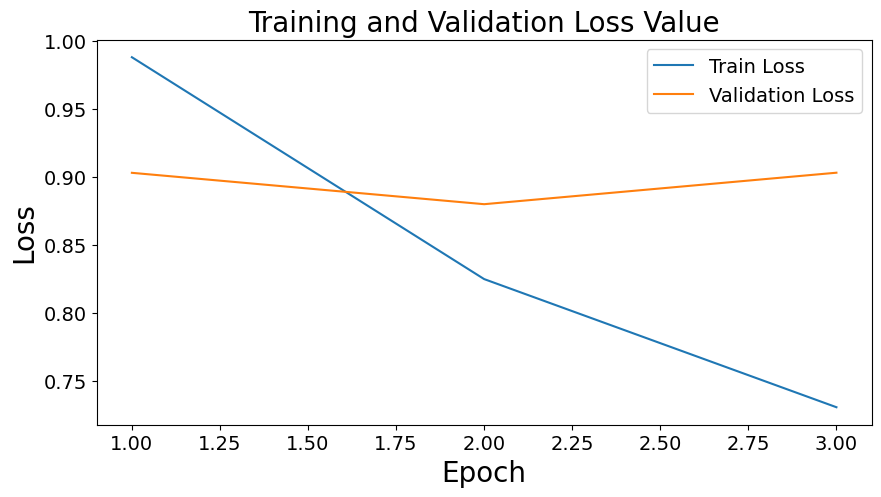

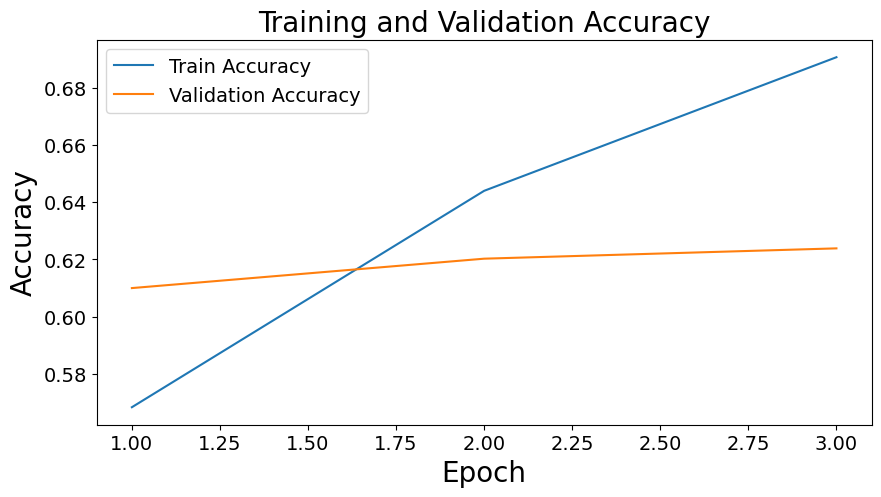

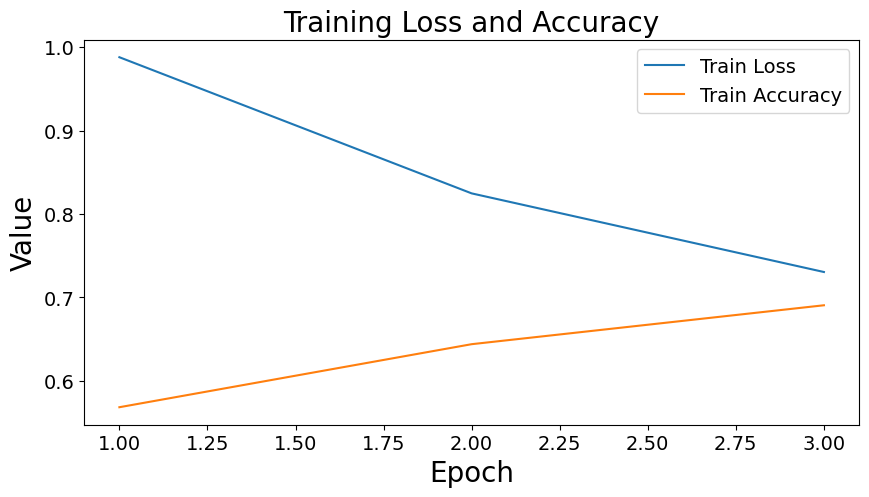

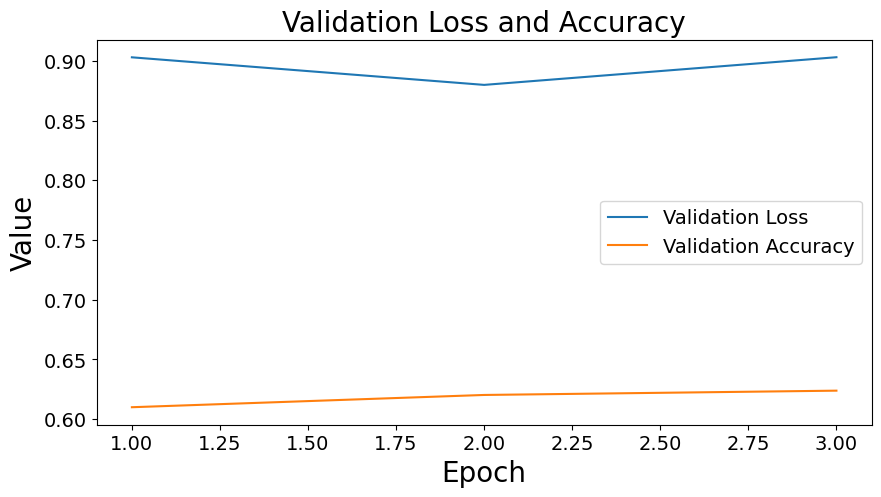

In [20]:
epochs_range = range(1, epochs + 1)

# 1) Training and Validation Loss Value
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Value')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3) Training Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# 4) Validation Loss and Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# YELP

# Install tools

> uncomment to install

# Dataset

In [4]:
# !curl -L -o ./yelp-review-dataset.zip https://www.kaggle.com/api/v1/datasets/download/ilhamfp31/yelp-review-dataset
# !unzip yelp-review-dataset.zip -d yelp-review-dataset

# Train-test split (manual, since we have separate documents for each set)

In [5]:
train_df = pd.read_csv('./yelp-review-dataset/yelp_review_polarity_csv/train.csv', names=['label', 'text'], header=None)
test_df = pd.read_csv('./yelp-review-dataset/yelp_review_polarity_csv/test.csv', names=['label', 'text'], header=None)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (560000, 2)
Test shape: (38000, 2)


In [6]:
train_subset = pd.concat([
    train_df[train_df.label == 1].sample(10000, random_state=42),  # Negative class
    train_df[train_df.label == 2].sample(10000, random_state=42)   # Positive class
])

print("Train shape:", train_subset.shape)

train_subset.head()

Train shape: (20000, 2)


,label,text
392225,1,I do enjoy Taco Bell from time to time but I h...
451725,1,My sister and I are pretty great guest at rest...
286059,1,Le vrai four \u00e0 bois \u00e0 l'entr\u00e9e ...
416667,1,Felt discriminated because I came there in a s...
321560,1,Absolutely AWFUL service. \nWe were originally...


In [7]:
test_subset = pd.concat([
    test_df[test_df.label == 1].sample(1000, random_state=42),
    test_df[test_df.label == 2].sample(1000, random_state=42)
])

print("Train shape:", test_subset.shape)

test_subset.head()

Train shape: (2000, 2)


,label,text
14418,1,Worst Starbucks I've ever been to! The staff i...
23484,1,F*ck this place. Maybe the location in Tempe i...
34574,1,"Stayed at the Hakone Suite, room is fantastic ..."
35679,1,"This place sucks. It's small, and their adver..."
36982,1,Ate there for the first and last time. Let me...


In [8]:
train_subset = train_subset.sample(frac=1, random_state=42).reset_index(drop=True)
test_subset = test_subset.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
train_subset['label'] = train_subset['label'].replace({1:0, 2:1})
test_subset['label'] = test_subset['label'].replace({1:0, 2:1})

print("Train shape:", train_subset.shape)
print("Test shape:", test_subset.shape)

Train shape: (20000, 2)
Test shape: (2000, 2)


Data Prepprocessing steps:


1.   Replacing special characters
2.   Remove punctuation and numbers
3.   Case folding
4.   Tokenization
5.   Stop word removal
6.   Lemmatization



In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to /home/rakhat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rakhat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
def preprocess(text):
    text = text.replace('\\"', ' ').replace('\\n', ' ')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'very'}
    tokens = [word for word in tokens if word not in stop_words]
    #lemmatizer = WordNetLemmatizer()
    #tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

In [13]:
# Apply preprocessing
train_subset['processed'] = train_subset['text'].apply(preprocess)
test_subset['processed'] = test_subset['text'].apply(preprocess)

# BERT Model

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [16]:
from torch.utils.data import DataLoader

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

max_len = 100

train_dataset = ReviewDataset(train_subset['processed'], train_subset['label'], tokenizer, max_len)
test_dataset = ReviewDataset(test_subset['processed'], test_subset['label'], tokenizer, max_len)

# Model Training and Evaluation

In [17]:
from tqdm import tqdm

def train(model, data_loader, optimizer, scheduler, device):
    model.train()  # set model to training mode
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm to have a progress bar
    for batch in tqdm(data_loader, desc='Training', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()        # reset gradients
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Backprop
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        
        # Predictions & Accuracy
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = correct / total if total > 0 else 0
    
    return avg_acc, avg_loss


def evaluate(model, data_loader, device):
    model.eval()  # set model to evaluation mode
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            epoch_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = epoch_loss / len(data_loader)
    avg_acc = correct / total if total > 0 else 0
    
    return avg_acc, avg_loss

In [18]:
from tabulate import tabulate

def train_with_progress(model, train_dataset, val_dataset, optimizer, scheduler, device, batch_size=16, epochs=3, model_name="BERT"):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    print(f"\n{'='*40}")
    print(f"Training {model_name} (Batch Size: {batch_size})")
    print(f"{'='*40}")

    results = []
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
        val_acc, val_loss = evaluate(model, val_loader, device)
        
        results.append([epoch+1, train_acc, val_acc, train_loss, val_loss])
        print(f"Epoch {epoch+1} -- Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
    
    print(f"\n{model_name} Epoch Results:")
    print(tabulate(results,
                   headers=["Epoch", "Train Acc", "Val Acc", "Train Loss", "Val Loss"],
                   floatfmt=".4f"))
    return results

In [19]:
# # MLP model
# import time

# mlp_results = []
# for batch_size in [32, 64, 128]:
#     model_mlp = Sequential([
#         Embedding(20000, 300, weights=[embedding_matrix], input_length=100, trainable=False),
#         Flatten(),
#         Dense(32, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     start_time = time.time()
#     history = train_with_progress(
#         model_mlp, X_train, train_subset['label'],
#         X_test, test_subset['label'],
#         batch_size=batch_size,
#         model_name="MLP"
#     )
#     print(f"Training completed in {time.time()-start_time:.2f}s")
#     mlp_results.append({
#         'batch_size': batch_size,
#         'model': model_mlp,
#         'history': history,
#         'final_val_acc': history.history['val_accuracy'][-1]
#     })

import torch
import time
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_scheduler

bert_results = []

for batch_size in [16, 32]:
    print(f"\n--- Starting run with batch size {batch_size} ---")

    # Initialize fresh model for each run
    model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    model = model.to(device)

    # Optimizer and scheduler setup
    optimizer = AdamW(model.parameters(), lr=2e-5)
    num_training_steps = len(train_dataset) // batch_size * 3  # 3 epochs
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    start_time = time.time()
    
    results = train_with_progress(
        model=model,
        train_dataset=train_dataset,
        val_dataset=test_dataset,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        batch_size=batch_size,
        epochs=3,
        model_name="BERT"
    )
    
    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f}s")
    
    bert_results.append({
        'batch_size': batch_size,
        'model': model,
        'results': results,
        'duration': duration
    })

2025-04-03 23:05:06.457368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743703506.468919  361924 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743703506.472603  361924 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743703506.483091  361924 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743703506.483108  361924 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743703506.483110  361924 computation_placer.cc:177] computation placer alr


--- Starting run with batch size 16 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT (Batch Size: 16)

Epoch 1/3


Epoch 1 -- Train Acc: 0.8820, Train Loss: 0.2789, Val Acc: 0.9145, Val Loss: 0.2152

Epoch 2/3


Epoch 2 -- Train Acc: 0.9458, Train Loss: 0.1439, Val Acc: 0.9205, Val Loss: 0.2042

Epoch 3/3


Epoch 3 -- Train Acc: 0.9814, Train Loss: 0.0575, Val Acc: 0.9230, Val Loss: 0.2839

BERT Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.8820     0.9145        0.2789      0.2152
      2       0.9458     0.9205        0.1439      0.2042
      3       0.9814     0.9230        0.0575      0.2839
Training completed in 1138.07s

--- Starting run with batch size 32 ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT (Batch Size: 32)

Epoch 1/3


Epoch 1 -- Train Acc: 0.8773, Train Loss: 0.2851, Val Acc: 0.9140, Val Loss: 0.2119

Epoch 2/3


Epoch 2 -- Train Acc: 0.9404, Train Loss: 0.1557, Val Acc: 0.9155, Val Loss: 0.2202

Epoch 3/3


Epoch 3 -- Train Acc: 0.9722, Train Loss: 0.0814, Val Acc: 0.9205, Val Loss: 0.2573

BERT Epoch Results:
  Epoch    Train Acc    Val Acc    Train Loss    Val Loss
-------  -----------  ---------  ------------  ----------
      1       0.8773     0.9140        0.2851      0.2119
      2       0.9404     0.9155        0.1557      0.2202
      3       0.9722     0.9205        0.0814      0.2573
Training completed in 1265.43s


In [24]:
print("\nBERT Final Comparison:")
print(tabulate([
    [16, bert_results[0]['results'][-1][2]],
    [32, bert_results[1]['results'][-1][2]],
], headers=["Batch Size", "Val Accuracy"], floatfmt=".4f"))


BERT Final Comparison:
  Batch Size    Val Accuracy
------------  --------------
          16          0.9230
          32          0.9205


In [27]:
def plot_model_progress(results, model_name, batch_size):
    # Unpack metrics
    epochs = [r[0] for r in results]
    train_acc = [r[1] for r in results]
    val_acc = [r[2] for r in results]
    train_loss = [r[3] for r in results]
    val_loss = [r[4] for r in results]

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Train')
    plt.plot(epochs, val_acc, 'r--', label='Validation')
    plt.title(f'{model_name} (Batch {batch_size})\nAccuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.4, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Train')
    plt.plot(epochs, val_loss, 'r--', label='Validation')
    plt.title(f'{model_name} (Batch {batch_size})\nLoss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


BERT Training Progress:


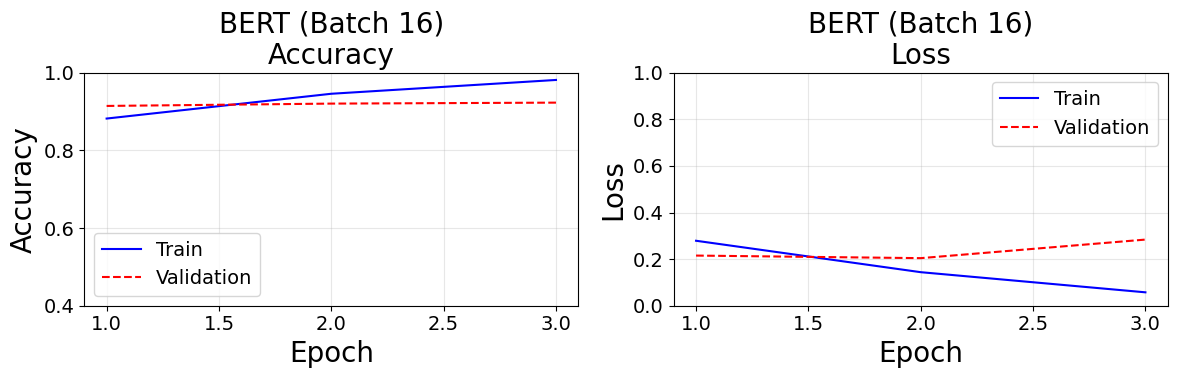

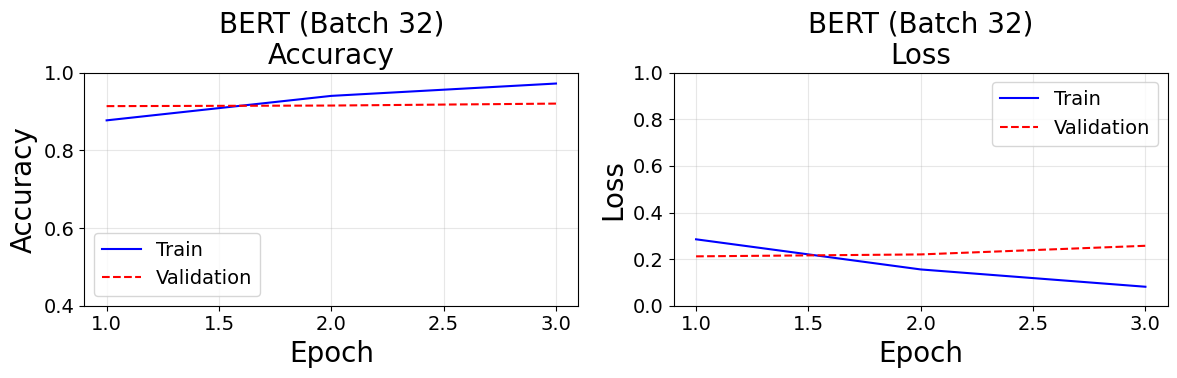

In [28]:
print("BERT Training Progress:")
for result in bert_results:
    plot_model_progress(
        result['results'],
        model_name="BERT",
        batch_size=result['batch_size']
    )

In [36]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, model_name, batch_size):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} (Batch {batch_size})\nConfusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

In [37]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return true_labels, predictions

<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:11: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:11: SyntaxWarning: invalid escape sequence '\B'
/tmp/ipykernel_361924/2451354342.py:1: SyntaxWarning: invalid escape sequence '\B'
  print("\BERT Confusion Matrices:")
/tmp/ipykernel_361924/2451354342.py:11: SyntaxWarning: invalid escape sequence '\B'
  print(f"\BERT Batch {result['batch_size']} Confusion Matrix:")


\BERT Confusion Matrices:

Evaluating model with batch size 16...


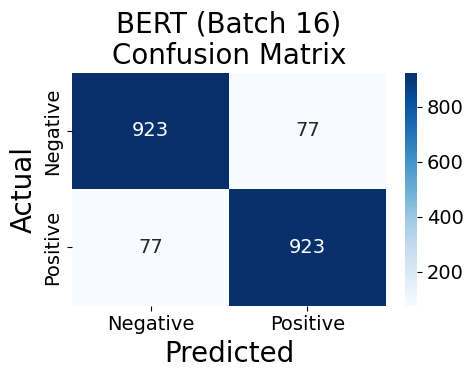

\BERT Batch 16 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  923 |                   77 |
+-----------------+----------------------+----------------------+
| Actual Positive |                   77 |                  923 |
+-----------------+----------------------+----------------------+

Evaluating model with batch size 32...


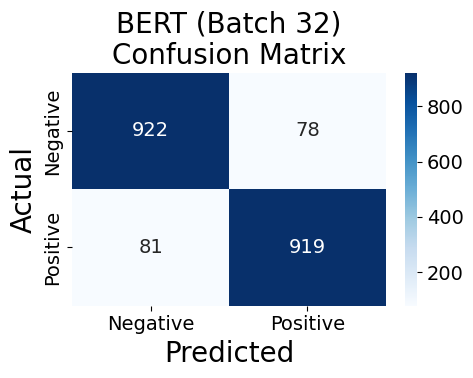

\BERT Batch 32 Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                  922 |                   78 |
+-----------------+----------------------+----------------------+
| Actual Positive |                   81 |                  919 |
+-----------------+----------------------+----------------------+


In [38]:
print("\BERT Confusion Matrices:")
for result in bert_results:
    print(f"\nEvaluating model with batch size {result['batch_size']}...")
    test_loader = DataLoader(test_dataset, batch_size=result['batch_size'])

    y_true, y_pred = get_predictions(result['model'], test_loader, device)
    cm = confusion_matrix(y_true, y_pred)
    
    plot_confusion_matrix(cm, "BERT", result['batch_size'])
    
    print(f"\BERT Batch {result['batch_size']} Confusion Matrix:")
    print(tabulate([[cm[0,0], cm[0,1]], [cm[1,0], cm[1,1]]],
                  headers=['Predicted Negative', 'Predicted Positive'],
                  showindex=['Actual Negative', 'Actual Positive'],
                  tablefmt='grid'))